# Проект: Предсказание покупательской активности на основе пользовательского поведения

## Введение

В рамках данного проекта проводится анализ пользовательской активности для  одного крупного онлайн-магазина. На основе истории покупок и взаимодействия с рекламными рассылками предстоит построить модель, которая сможет оценить вероятность совершения покупки в ближайшие 90 дней.

## Цель проекта

Целью проекта является создание и оптимизация модели бинарной классификации, которая предсказывает вероятность того, что клиент совершит покупку в течение 90 дней после момента наблюдения.

## Описание данных

В распоряжении имеются три датасета:

**apparel-purchases** - данные о покупках клиентов:
* client_id идентификатор пользователя
* quantity количество товаров в заказе
* price цена товара
* category_ids вложенные категории, к которым отнсится товар
* date дата покупки
* message_id идентификатор сообщения из рассылки

**apparel-messages** - история рекламных рассылок
* bulk_campaign_id идентификатор рекламной кампании
* client_id идентификатор пользователя
* message_id идентификатор сообщений
* event тип действия
* channel канал рассылки
* date дата рассылки
* created_at точное время создания сообщения
  
**apparel-target_binary** - совершит ли клиент покупку в течение следующих 90 дней
* client_id идентификатор пользователя
* target целевой признак

## План выполнения проекта

* Загрузка данных
* Предобработка данных
* Исследовательский анализ
* Подготовка признаков
* Корреляционный анализ
* Обучение моделей
* Анализ важности признаков
* Общий вывод

## Подготовка рабочего пространства

In [1]:
# установим необходимые библотеки
!pip install shap -q
!pip install phik -q
!pip install lightgbm -q

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from phik import resources
import shap
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# импортируем функции для визуализации данных из моей библиотеки
# Linux, macOS:
#!wget https://raw.githubusercontent.com/EgorTatarnikov/42_Purchasing_activity_prediction/blob/main/ds_lib_tatarnikov.py
# Windows:
!curl -o ds_lib_tatarnikov.py https://raw.githubusercontent.com/EgorTatarnikov/42_Purchasing_activity_prediction/main/ds_lib_tatarnikov.py
from ds_lib_tatarnikov import (
    show_plot,
    print_corr_levels
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25590  100 25590    0     0  52054      0 --:--:-- --:--:-- --:--:-- 52224
100 25590  100 25590    0     0  52037      0 --:--:-- --:--:-- --:--:-- 52224


In [4]:
# отключим все предупреждения о будущем удалении устаревших опций
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [6]:
# настройки отображения таблиц
pd.options.display.max_columns = None

## 1 Загрузка данных

**1.1 Откроем файлы с данными**

**apparel-purchases**

In [7]:
try:
    df_p = pd.read_csv('filtered_data/apparel-purchases.csv')
    print('Открыт локальный файл')
except:
    file_id = '1bMaNawHL-JP4m_Qv_ZoPfUq3EnJly7mX' # https://drive.google.com/file/d/1bMaNawHL-JP4m_Qv_ZoPfUq3EnJly7mX/view?usp=drive_link
    url = f'https://drive.google.com/uc?id={file_id}'
    df_p = pd.read_csv(url)
    print('Открыт файл из облака')

Открыт локальный файл


**apparel-messages**

In [8]:
try:
    df_m = pd.read_csv('filtered_data/apparel-messages.csv')
    print('Открыт локальный файл')
except:
    file_id = '1i7XcSo6F4z3x5KvLnQBJQfZFcTqTl6jB' # https://drive.google.com/file/d/1i7XcSo6F4z3x5KvLnQBJQfZFcTqTl6jB/view?usp=drive_link
    url = f'https://drive.google.com/uc?id={file_id}'
    df_m = pd.read_csv(url)
    print('Открыт файл из облака')

Открыт локальный файл


**apparel-target_binary**

In [9]:
try:
    df_t = pd.read_csv('filtered_data/apparel-target_binary.csv')
    print('Открыт локальный файл')
except:
    file_id = '1lzA7WMbG7eRVjn4mFltQY0QIdIG0iAgV' # https://drive.google.com/file/d/1lzA7WMbG7eRVjn4mFltQY0QIdIG0iAgV/view?usp=drive_link
    url = f'https://drive.google.com/uc?id={file_id}'
    df_t = pd.read_csv(url)
    print('Открыт файл из облака')

Открыт локальный файл


**1.2 Изучим общую информацию о датафреймах**

**apparel-purchases**

Выведем первые строки и общую информацию о датафрейме с данными о покупках.

In [10]:
df_p.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [11]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Таблица с данными о покупках клиентов состоит из 6 столбцов и 202208 строк. Пропусков нет. Данные в столбце с датой необходимо привести к формату datetime. Нужно изучить данные в столбце с категориями, чтобы понять как обрабатывать данный столбец.

**apparel-messages**

Выведем первые строки и общую информацию о датафрейме с данными о рекламных раcсылках.

In [12]:
df_m.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [13]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [14]:
# посмотрим наличие пропусков
df_m[df_m.isna().any(axis=1)]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at


Таблица с данными о рекламных сообщениях состоит из 7 столбцов и 12_739_798 строк. Пропусков нет. Данные в столбцах date и created_at необходимо привести к формату datetime.

**apparel-target_binary**

Выведем первые строки и общую информацию о датафрейме с целевым признаком.

In [15]:
df_t.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [16]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Таблица с целевым признаком состоит из 2 столбцов и 49849 строк. Пропусков нет. Типы данных соответствуют данным.

## 2 Предобработка данных

**2.1 Приведение типов данных**

Столбцы с датами приведем к типу datetime.

In [17]:
df_p['date'] = pd.to_datetime(df_p['date'], errors='coerce')
df_m['date'] = pd.to_datetime(df_m['date'], errors='coerce')
df_m['created_at'] = pd.to_datetime(df_m['created_at'], errors='coerce')

Столбцы с id клиента,id рекламной кампании и id рекламного сообщения приведем к типу string.

In [18]:
df_p['client_id'] = df_p['client_id'].astype(str)
df_p['message_id'] = df_p['message_id'].astype(str)

df_m['client_id'] = df_m['client_id'].astype(str)
df_m['message_id'] = df_m['message_id'].astype(str)
df_m['bulk_campaign_id'] = df_m['bulk_campaign_id'].astype(str)

df_t['client_id'] = df_t['client_id'].astype(str)

Переведем столбец с целевым признаком в тип category.

In [19]:
df_t['target'] = df_t['target'].astype('category')

**2.2 Поиск дубликатов**

**apparel-purchases**

In [20]:
temp = df_p.duplicated().sum()
print(f"В таблице с покупками имеется {temp} явных дубликата.")

В таблице с покупками имеется 73020 явных дубликата.


Посмотрим внимательнее на строки с дубликатами.

In [21]:
df_p[df_p.duplicated(keep=False)].head(6)

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa


Посмотрим может ли быть такое, что клиент совершал в один день покупку товаров из одной категории на основе одного и того же рекламного сообщения. Опустим столбец с ценой и посмотрим, есть ли дубликаты.

In [22]:
df_p.drop('price', axis=1).duplicated().sum()

105048

Да, такие дубликаты есть. Получается, что есть вероятность, что строки в таблице продублированы не случайно. Клиенты совершали повторные покупки одного и того же товара.

**apparel-messages**

In [23]:
temp = df_m.duplicated().sum()
print(f"В таблице с рекламными сообщениями имеется {temp} явных дубликатов.")

В таблице с рекламными сообщениями имеется 48610 явных дубликатов.


In [24]:
df_m[df_m.duplicated(keep=False)].head(6)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966465,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967281,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56


В данной таблице либо строки подублированы случайно, либо клиент дважды совершал действие с рекламным сообщением за одну секунду

Удалим дубликаты.

In [25]:
df_m.drop_duplicates(inplace=True)

**apparel-target_binary**

In [26]:
temp = df_t.duplicated().sum()
print(f"В таблице с целевым признаком {temp} дубликатов.")

В таблице с целевым признаком 0 дубликатов.


**Промежуточный итог:**

В ходе предобработки данных датасеты были подготовлены к дальнейшему анализу. Данные приведены к соответствующим типам. Проведен поиск дубликатов - дубликаты удалены.

## 3 Исследовательский анализ данных

Для понятной визуализации информации запишем названия признаков на русском языке.

In [27]:
# перевод таблиц с английского на русский
eng_to_rus = {
    # apparel-purchases
    "client_id": "ID клиента",
    "quantity": "Количество",
    "price": "Цена",
    "category_ids": "Категории товара",
    "date": "Дата покупки",
    "message_id": "ID сообщения из рассылки",
    
    # apparel-messages
    "bulk_campaign_id": "ID рассылки",
    "event": "Действие",
    "channel": "Канал рассылки",
    "created_at": "Дата и время действия",

    # target
    "target": "Совершена покупка в целевом периоде",
    1: "Да",
    0: "Нет",
}

event_n_channel_translate = {
    'send': 'Отправлено',
    'open': 'Открыто',
    'click': 'Переход по ссылке',
    'purchase': 'Покупка',
    'hard_bounce': 'Жёсткий отказ (не доставлено)',
    'soft_bounce': 'Мягкий отказ (временно не доставлено)',
    'unsubscribe': 'Отписка',
    'hbq_spam': 'Помечено как спам',
    'complain': 'Жалоба',
    'subscribe': 'Подписка',
    'close': 'Окно закрыто',
    'email': 'Email',
    'mobile_push': 'Push-уведомление'
}

Создадим копии датафреймов и переведем их на русский язык.

In [28]:
df_p_rus = df_p.copy()
df_p_rus.rename(columns=eng_to_rus, inplace=True)
df_p_rus.head()

,ID клиента,Количество,Цена,Категории товара,Дата покупки,ID сообщения из рассылки
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [29]:
df_m_rus = df_m.copy()
df_m_rus.rename(columns=eng_to_rus, inplace=True)
df_m_rus.rename(columns={'Дата покупки': 'Дата рассылки'}, inplace=True)
df_m_rus = df_m_rus.replace(event_n_channel_translate)
df_m_rus.head()

,ID рассылки,ID клиента,ID сообщения из рассылки,Действие,Канал рассылки,Дата рассылки,Дата и время действия
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,Открыто,Email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,Открыто,Email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,Открыто,Email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,Переход по ссылке,Email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,Открыто,Email,2022-05-19,2022-05-19 00:56:52


In [30]:
df_t_rus = df_t.copy()
df_t_rus.rename(columns=eng_to_rus, inplace=True)
df_t_rus = df_t_rus.replace(eng_to_rus)
df_t_rus.head()

,ID клиента,Совершена покупка в целевом периоде
0,1515915625468060902,Нет
1,1515915625468061003,Да
2,1515915625468061099,Нет
3,1515915625468061100,Нет
4,1515915625468061170,Нет


**3.1 Статистический анализ**

Посмотрим статистическое описание данных.

**apparel-purchases**

In [31]:
df_p_rus.describe(include='all')

,ID клиента,Количество,Цена,Категории товара,Дата покупки,ID сообщения из рассылки
count,202208,202208.000000,202208.000000,202208,202208,202208
unique,49849,NaN,NaN,933,642,50204
top,1515915625853312319,NaN,NaN,"['4', '28', '57', '431']",2022-11-11 00:00:00,1515915625489095763-6251-6311b13a4cf78
freq,346,NaN,NaN,8626,5270,365
first,NaN,NaN,NaN,NaN,2022-05-16 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2024-02-16 00:00:00,NaN
mean,NaN,1.006483,1193.301516,NaN,NaN,NaN
std,NaN,0.184384,1342.252664,NaN,NaN,NaN
min,NaN,1.000000,1.000000,NaN,NaN,NaN
25%,NaN,1.000000,352.000000,NaN,NaN,NaN


In [32]:
print(df_p_rus['Дата покупки'].max() - df_p_rus['Дата покупки'].min())

641 days 00:00:00


Данные находятся в реальных диапазонах. Явных аномалий нет. Есть покупки с ценой 1, что может объясняться особенностями акций. Имеются 933 уникальные категории товаров. Данные о покупках есть за каждый день с 2022-05-16 по 2024-02-16.

**apparel-messages**

In [33]:
df_m_rus.describe(include='all')

,ID рассылки,ID клиента,ID сообщения из рассылки,Действие,Канал рассылки,Дата рассылки,Дата и время действия
count,12691188,12691188,12691188,12691188,12691188,12691188,12691188
unique,2709,53329,9061667,11,2,638,4103539
top,14272,1515915625516327994,1515915625489095763-6251-6311b13a4cf78,Отправлено,Push-уведомление,2023-06-10 00:00:00,2023-12-29 15:20:53
freq,104060,3088,1427,9058174,7470472,89173,608
first,NaN,NaN,NaN,NaN,NaN,2022-05-19 00:00:00,2022-05-19 00:14:20
last,NaN,NaN,NaN,NaN,NaN,2024-02-15 00:00:00,2024-02-15 23:58:40


В таблице представленно больше уникальных клиентов, чем в таблице с покупками и таргетом. Имеется два основных канала рассылки рекламных сообщений и 11 видов действий с сообщениями.

**apparel-target_binary**

In [34]:
df_t_rus.describe(include='all')

,ID клиента,Совершена покупка в целевом периоде
count,49849,49849
unique,49849,2
top,1515915625752286429,Нет
freq,1,48888


In [35]:
count = df_t_rus['Совершена покупка в целевом периоде'].count()
temp = df_t_rus['Совершена покупка в целевом периоде'].value_counts()[1]/count*100
print(f'В таблице с целевым признаком предсталены {count} клиентов из которых {temp: .2f}% совершили покупку в целевом периоде.')

В таблице с целевым признаком предсталены 49849 клиентов из которых  1.93% совершили покупку в целевом периоде.


**3.2 Визуализация статистических данных**

**apparel-purchases**

Пострим гистограмму для признака "Цена".

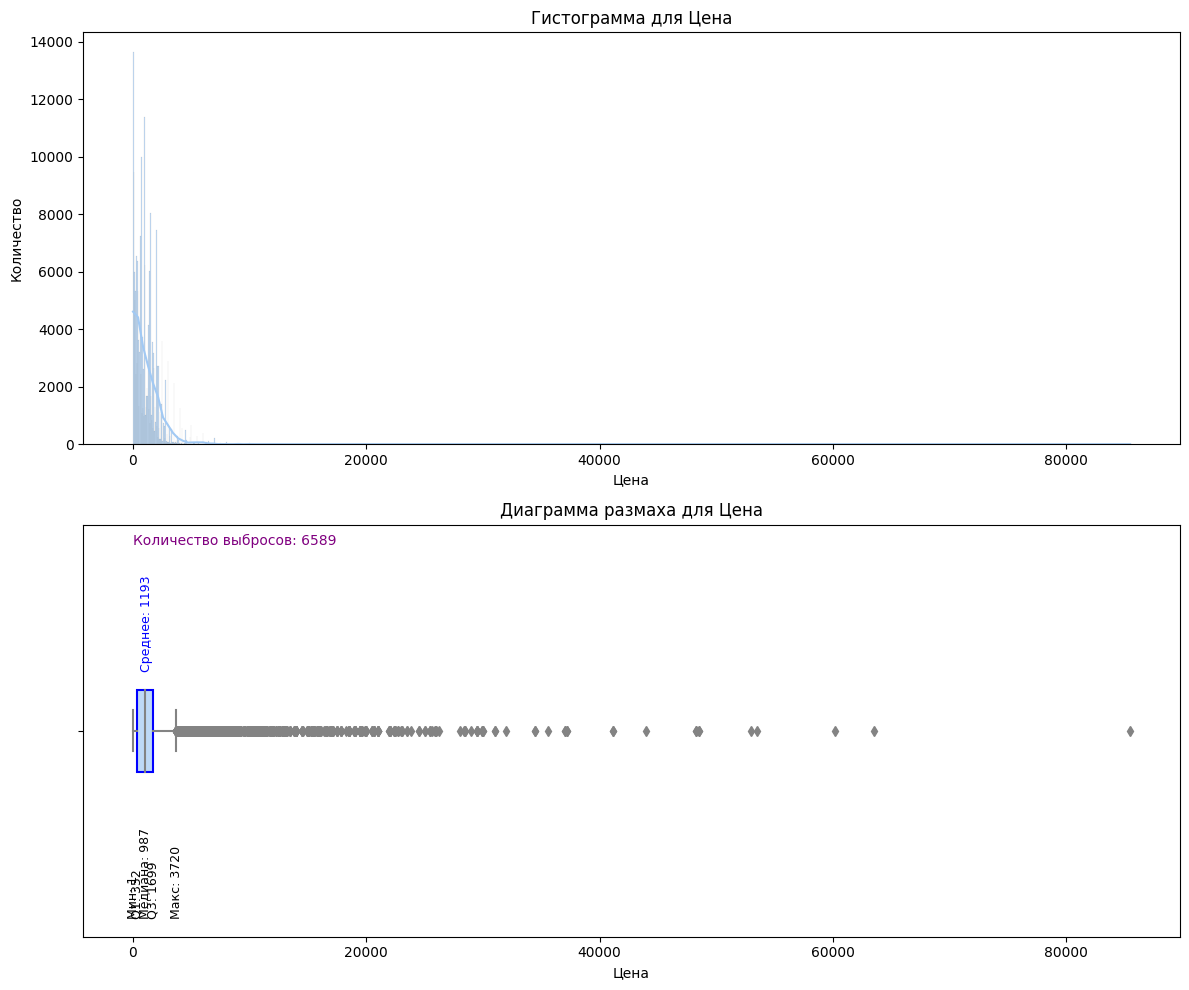

In [36]:
show_plot(df_p_rus, 'Цена')

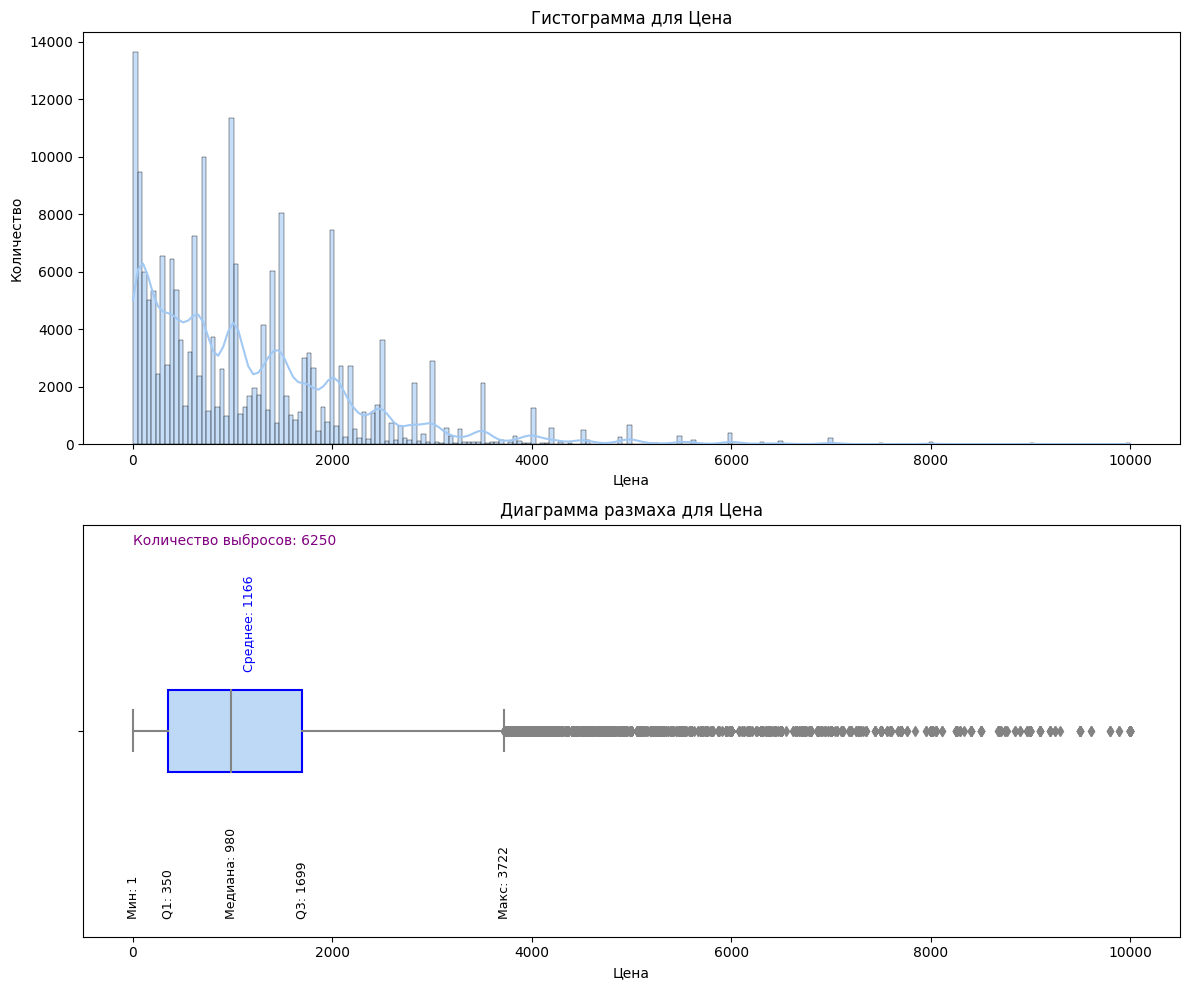

In [37]:
show_plot(df_p_rus[df_p_rus['Цена'] < 10000], 'Цена')

Цены товаров изменяются в диапазоне от 1 до 85499. 

Средняя цена 980.

Межквартильый размах от 350 до 1699.

Покупки дороже 3722 можно считать аномально дорогими.

Пострим диаграмму частот для количества единиц товаров за одну покупку.

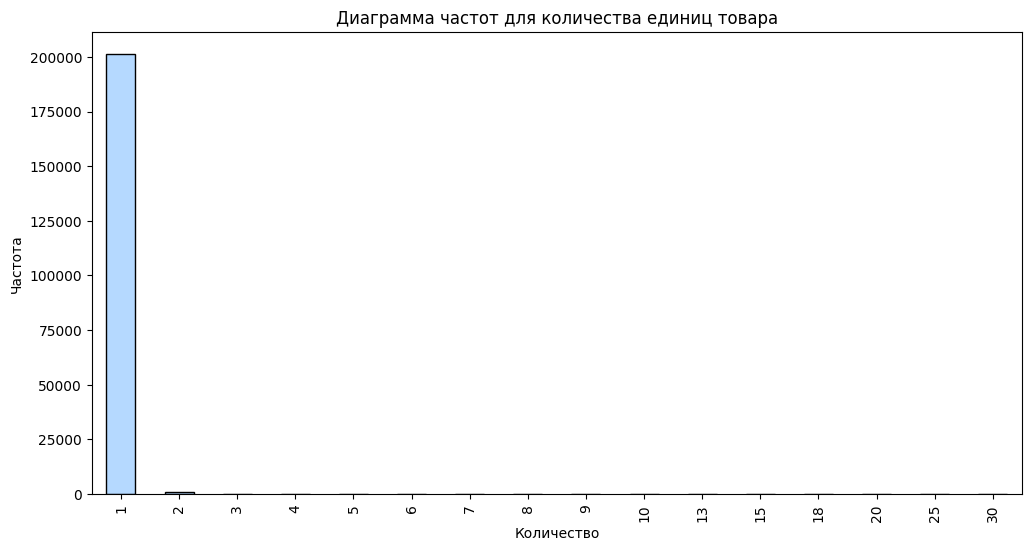

In [38]:
df_p_rus['Количество'].value_counts().sort_index().plot(
    kind='bar', 
    figsize=(12,6),
    color='#b5d9ff',
    edgecolor="black",
)
plt.xlabel('Количество')
plt.ylabel('Частота')
plt.title('Диаграмма частот для количества единиц товара')
plt.show()

In [39]:
df_p_rus[df_p_rus['Количество'] == 1]['Количество'].count() / df_p_rus['Количество'].count() * 100

99.56233185630637

В 99.5% случаях, клиент покупает один товар.

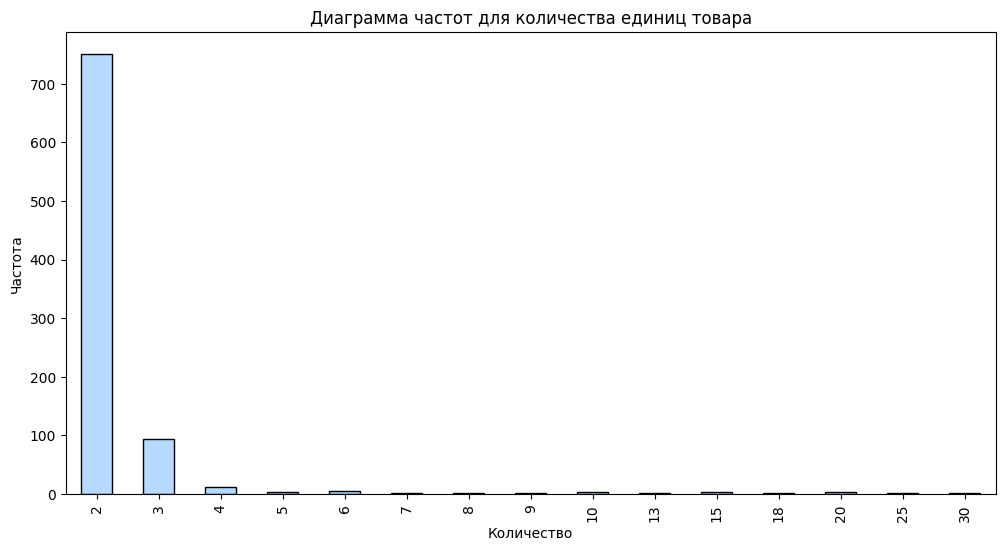

In [40]:
df_p_rus[df_p_rus['Количество'] > 1]['Количество'].value_counts().sort_index().plot(
    kind='bar', 
    figsize=(12,6),
    color='#b5d9ff',
    edgecolor="black",
)
plt.xlabel('Количество')
plt.ylabel('Частота')
plt.title('Диаграмма частот для количества единиц товара')
plt.show()

Количество товаров за покупку больше 3х встречается крайне редко.

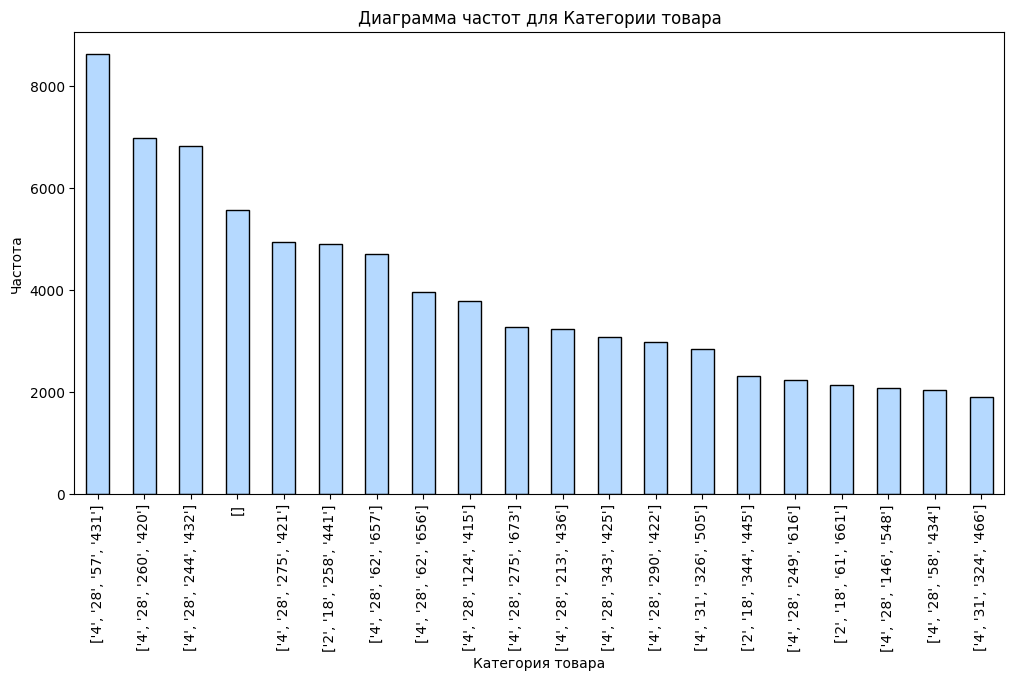

In [41]:
df_p_rus['Категории товара'].value_counts().head(20).plot(
    kind='bar', 
    figsize=(12,6),
    color='#b5d9ff',
    edgecolor="black",
)
plt.xlabel('Категория товара')
plt.ylabel('Частота')
plt.title('Диаграмма частот для Категории товара')
plt.show()

Наиболее популярные категории товаров имеют подкатегории ['4', '28', x , x].

**apparel-messages**

Построим диаграмму частот для действия с рекламным сообщением.

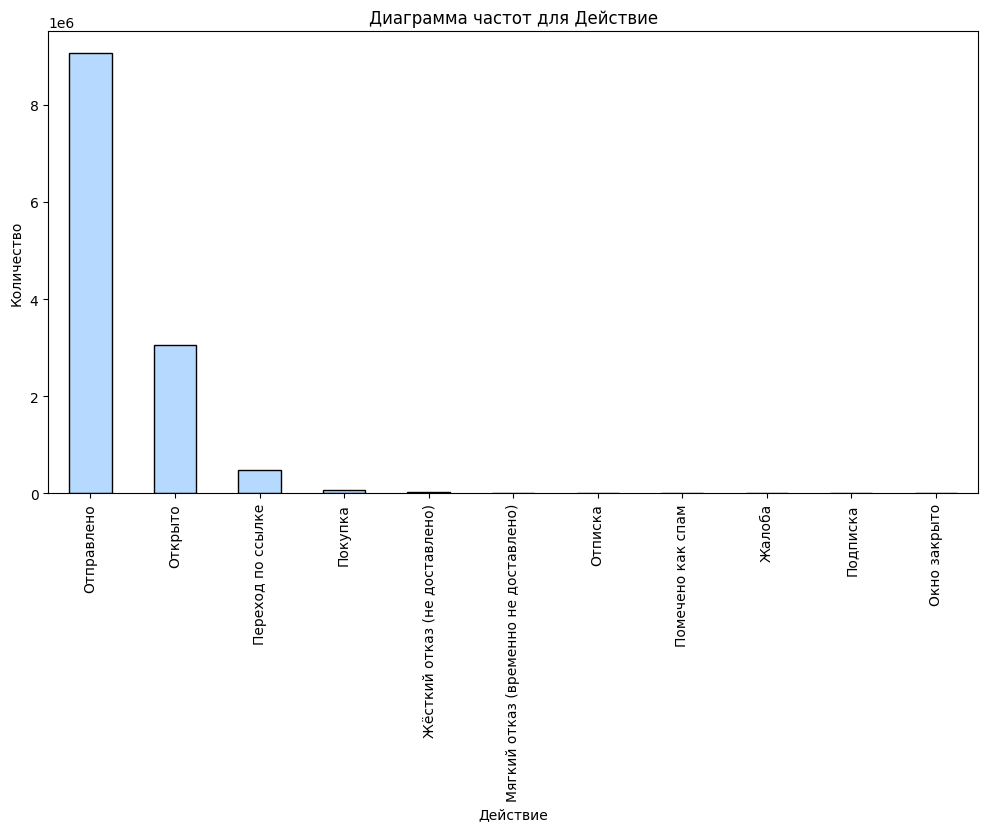

In [42]:
df_m_rus['Действие'].value_counts().plot(
    kind='bar', 
    figsize=(12,6),
    color='#b5d9ff',
    edgecolor="black",
)
plt.xlabel('Действие')
plt.ylabel('Количество')
plt.title('Диаграмма частот для Действие')
plt.show()

In [43]:
df_m_rus[df_m_rus['Действие'] == 'Покупка']['Действие'].count() / df_m_rus['Действие'].count() * 100

0.49320047894649427

Наиболее часто рекламные сообщения остаются непрочитанными. В 0,5% случаев клиенты, просмотрев рекламу, совершают покупку.

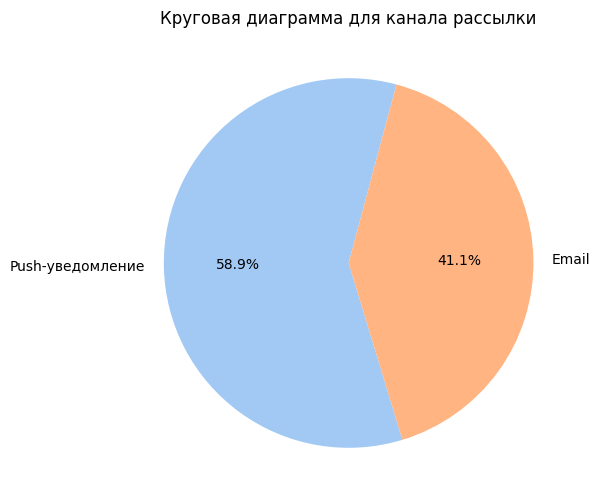

In [44]:
df_m_rus['Канал рассылки'].value_counts().plot(
    kind='pie',
    figsize=(6, 6),
    autopct='%1.1f%%',
    startangle=75,
    colors=sns.color_palette('pastel'),
    #wedgeprops={'edgecolor': 'black'}
)
plt.ylabel('')
plt.title('Круговая диаграмма для канала рассылки')
plt.show()

**apparel-target_binary**

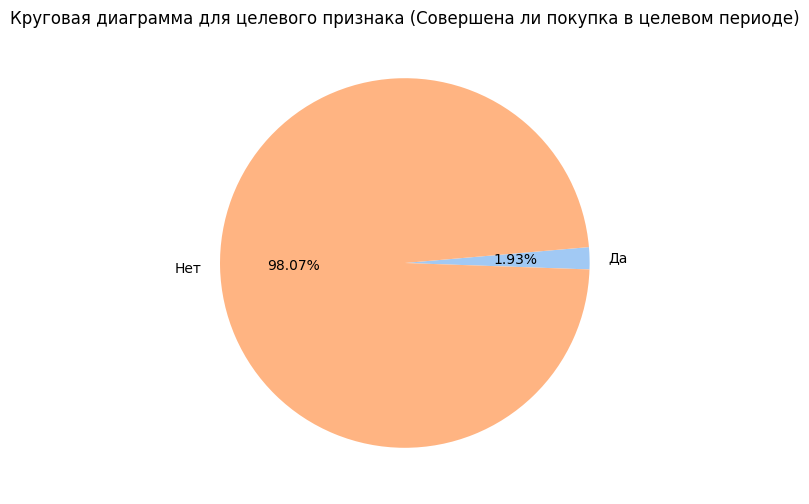

In [45]:
df_t_rus['Совершена покупка в целевом периоде'].value_counts().sort_index().plot(
    kind='pie',
    figsize=(6, 6),
    autopct='%1.2f%%',
    startangle=-2,
    colors=sns.color_palette('pastel'),
    #wedgeprops={'edgecolor': 'black'}
)
plt.ylabel('')
plt.title('Круговая диаграмма для целевого признака (Совершена ли покупка в целевом периоде)')
plt.show()

In [46]:
target_weight_scale = df_t[df_t['target'] == 0]['target'].count() / df_t[df_t['target'] == 1]['target'].count()
print(f'{target_weight_scale:.2f}')

50.87


Имеется дисбаланс классов в целевом признаке. Разница в 50,87 раз. 

In [47]:
del df_p_rus
del df_m_rus
del df_t_rus

**Промежуточный итог:**

Был проведен исследовательский анализ предоставленных данных. Для обучения моделей необходимо провести дополнительную подготовку признаков.

# 4 Подготовка признаков

**4.1 Подготовка таблицы с сообщениями**

Помотрим на таблицу с сообщениями, в результате взаимодействия с которыми были сделаны покупки.

In [48]:
df_m[df_m['event'] == 'purchase']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
27,4439,1515915625498693110,1515915625498693110-4439-62834130c8234,purchase,email,2022-05-19,2022-05-19 02:05:20
54,4439,1515915625558950747,1515915625558950747-4439-6283411f3ad55,purchase,email,2022-05-19,2022-05-19 03:15:19
58,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:19:12
61,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:25:13
62,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:27:40
...,...,...,...,...,...,...,...
12739704,14623,1515915625560731504,1515915625560731504-14623-65c5c586e5d16,purchase,mobile_push,2024-02-15,2024-02-15 21:09:59
12739707,14632,1515915625655214370,1515915625655214370-14632-65c9f60e5cee9,purchase,mobile_push,2024-02-15,2024-02-15 21:19:39
12739750,14656,1515915625585044070,1515915625585044070-14656-65cdbea44cf9e,purchase,mobile_push,2024-02-15,2024-02-15 22:33:19
12739751,14653,1515915625491746764,1515915625491746764-14653-65cdc49de4ac4,purchase,mobile_push,2024-02-15,2024-02-15 22:34:19


По одному сообщению может быть сделано несколько покупок.

Посмотрим на дубликаты учитывая только некоторые столбцы.

In [49]:
df_m[['client_id', 'message_id', 'event', 'channel']].duplicated().sum()

289832

In [50]:
df_m[['client_id', 'message_id', 'event']].duplicated().sum()

289832

In [51]:
df_m[['client_id', 'message_id']].duplicated().sum()

3629521

Видно, что с одним сообщением клиент может делать несколько действий.

Отбросим из анализа столбцы с датами, так как не получится их связать с датами из таблицы с покупками. Также уберем из анализа столбцы с id рекламной компании.

In [52]:
df_m = df_m[['client_id', 'message_id', 'event', 'channel']]

Отбросим появившиеся дубликаты

In [53]:
df_m.duplicated().sum()

289832

In [54]:
df_m.drop_duplicates(inplace=True)

Запомним уникальные значения из столбцов event и channel

In [55]:
event_types = df_m['event'].unique()
channel_types = df_m['channel'].unique()

Сгуппируем данные по двум столбцам client_id и message_id.

In [56]:
df_m = df_m.groupby(['client_id', 'message_id'])[['event', 'channel']].agg(list).reset_index()
df_m

,client_id,message_id,event,channel
0,1515915625468060902,1515915625468060902-10022-63e5ededd911f,[send],[email]
1,1515915625468060902,1515915625468060902-10218-63ef56ed94656,[send],[email]
2,1515915625468060902,1515915625468060902-10289-63f35a8a9ff35,[send],[email]
3,1515915625468060902,1515915625468060902-10373-63f5cbba42484,[send],[email]
4,1515915625468060902,1515915625468060902-10507-63ff04f701e74,[send],[email]
...,...,...,...,...
9061662,1515915626010221592,1515915626010221592-14648-65cdb6d2ab406,"[send, open]","[mobile_push, mobile_push]"
9061663,1515915626010221592,1515915626010221592-14653-65cdc49de879f,"[send, open, click]","[mobile_push, mobile_push, mobile_push]"
9061664,1515915626010234726,1515915626010234726-14656-65cdd2f839b78,[send],[mobile_push]
9061665,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,"[send, open, click]","[mobile_push, mobile_push, mobile_push]"


In [57]:
event_types = [
    'send',
    'open',
    'click',
    'purchase',
    'hard_bounce',
    'soft_bounce',
    'unsubscribe',
    'hbq_spam',
    'complain',
    'subscribe',
    'close'
]

for event in event_types:
    df_m[event] = df_m['event'].apply(lambda x: int(event in x))

In [58]:
channel_types = [
    'email',
    'mobile_push'
]

for channel in channel_types:
    df_m[channel] = df_m['channel'].apply(lambda x: int(channel in x))

In [59]:
df_m

,client_id,message_id,event,channel,send,open,click,purchase,hard_bounce,soft_bounce,unsubscribe,hbq_spam,complain,subscribe,close,email,mobile_push
0,1515915625468060902,1515915625468060902-10022-63e5ededd911f,[send],[email],1,0,0,0,0,0,0,0,0,0,0,1,0
1,1515915625468060902,1515915625468060902-10218-63ef56ed94656,[send],[email],1,0,0,0,0,0,0,0,0,0,0,1,0
2,1515915625468060902,1515915625468060902-10289-63f35a8a9ff35,[send],[email],1,0,0,0,0,0,0,0,0,0,0,1,0
3,1515915625468060902,1515915625468060902-10373-63f5cbba42484,[send],[email],1,0,0,0,0,0,0,0,0,0,0,1,0
4,1515915625468060902,1515915625468060902-10507-63ff04f701e74,[send],[email],1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061662,1515915626010221592,1515915626010221592-14648-65cdb6d2ab406,"[send, open]","[mobile_push, mobile_push]",1,1,0,0,0,0,0,0,0,0,0,0,1
9061663,1515915626010221592,1515915626010221592-14653-65cdc49de879f,"[send, open, click]","[mobile_push, mobile_push, mobile_push]",1,1,1,0,0,0,0,0,0,0,0,0,1
9061664,1515915626010234726,1515915626010234726-14656-65cdd2f839b78,[send],[mobile_push],1,0,0,0,0,0,0,0,0,0,0,0,1
9061665,1515915626010261344,1515915626010261344-14648-65cdb6d56c4c8,"[send, open, click]","[mobile_push, mobile_push, mobile_push]",1,1,1,0,0,0,0,0,0,0,0,0,1


Мы получили таблицу, в которой имеются все уникальные клиенты и рекламные сообщения, каналы рассылки и действия клиентов с этими сообщениями.
Сгруппируем таблицу по client_id, для message_id посчитаем количество, в столбцах с действием и каналам рассылки найдем сумму.

In [60]:
df_m_agg = df_m.groupby('client_id').agg(
    message_count=('message_id', 'count'),
    send=('send', 'sum'),
    open=('open', 'sum'),
    click=('click', 'sum'),
    purchase=('purchase', 'sum'),
    hard_bounce=('hard_bounce', 'sum'),
    soft_bounce=('soft_bounce', 'sum'),
    unsubscribe=('unsubscribe', 'sum'),
    hbq_spam=('hbq_spam', 'sum'),
    complain=('complain', 'sum'),
    subscribe=('subscribe', 'sum'),
    close=('close', 'sum'),
    email=('email', 'sum'),
    mobile_push=('mobile_push', 'sum')
).reset_index()

In [61]:
df_m_agg

,client_id,message_count,send,open,click,purchase,hard_bounce,soft_bounce,unsubscribe,hbq_spam,complain,subscribe,close,email,mobile_push
0,1515915625468060902,127,126,33,6,1,0,0,1,0,0,0,0,127,0
1,1515915625468061003,154,154,5,4,1,0,0,0,0,0,0,0,154,0
2,1515915625468061099,215,215,49,8,0,2,0,0,0,0,0,0,157,58
3,1515915625468061100,268,267,153,1,1,1,1,0,0,0,0,0,0,268
4,1515915625468061170,243,243,30,12,3,0,0,0,0,0,0,0,164,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,2,2,2,0,0,0,0,0,0,0,0,0,0,2
53325,1515915626010221592,2,2,2,1,0,0,0,0,0,0,0,0,0,2
53326,1515915626010234726,1,1,0,0,0,0,0,0,0,0,0,0,0,1
53327,1515915626010261344,1,1,1,1,0,0,0,0,0,0,0,0,0,1


**4.2 Подготовка таблицы с покупками**

In [62]:
df_p

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


Создадим для анализа следующие признаки: время с последней покупки и среднее время между покупками.

In [63]:
df_p_time = df_p.groupby('client_id')['date'].apply(lambda x: sorted(x)).reset_index()
df_p_time

,client_id,date
0,1515915625468060902,"[2022-05-27 00:00:00, 2022-05-27 00:00:00, 202..."
1,1515915625468061003,"[2023-01-04 00:00:00, 2023-01-04 00:00:00, 202..."
2,1515915625468061099,[2022-05-17 00:00:00]
3,1515915625468061100,"[2024-02-10 00:00:00, 2024-02-10 00:00:00]"
4,1515915625468061170,"[2023-03-26 00:00:00, 2023-03-26 00:00:00, 202..."
...,...,...
49844,1515915626010261344,"[2024-02-16 00:00:00, 2024-02-16 00:00:00, 202..."
49845,1515915626010266132,"[2024-02-14 00:00:00, 2024-02-14 00:00:00]"
49846,1515915626010439406,"[2024-02-16 00:00:00, 2024-02-16 00:00:00]"
49847,1515915626010443527,[2024-02-16 00:00:00]


Последний день в таблице с покупками 2024-02-16.

In [64]:
last_date = pd.to_datetime('2024-02-16')

In [65]:
# Расчёт признаков
def compute_time_features(dates):
    if len(dates) == 0:
        return pd.Series([None, None])
    days_last_purchase = (last_date - dates[-1]).days
    if len(dates) > 1:
        deltas = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
        avg_time_between = sum(deltas) / len(deltas)
    else:
        avg_time_between = None
    return pd.Series([days_last_purchase, avg_time_between])

df_p_time[['days_last_purchase', 'avg_days_between']] = df_p_time['date'].apply(compute_time_features)
df_p_time

,client_id,date,days_last_purchase,avg_days_between
0,1515915625468060902,"[2022-05-27 00:00:00, 2022-05-27 00:00:00, 202...",630.0,0.000000
1,1515915625468061003,"[2023-01-04 00:00:00, 2023-01-04 00:00:00, 202...",408.0,0.000000
2,1515915625468061099,[2022-05-17 00:00:00],640.0,NaN
3,1515915625468061100,"[2024-02-10 00:00:00, 2024-02-10 00:00:00]",6.0,0.000000
4,1515915625468061170,"[2023-03-26 00:00:00, 2023-03-26 00:00:00, 202...",244.0,4.611111
...,...,...,...,...
49844,1515915626010261344,"[2024-02-16 00:00:00, 2024-02-16 00:00:00, 202...",0.0,0.000000
49845,1515915626010266132,"[2024-02-14 00:00:00, 2024-02-14 00:00:00]",2.0,0.000000
49846,1515915626010439406,"[2024-02-16 00:00:00, 2024-02-16 00:00:00]",0.0,0.000000
49847,1515915626010443527,[2024-02-16 00:00:00],0.0,NaN


Сгуппируем данные по столбцу client_id, при этом посчитаем суммарное количество купленных товаров, среднюю цену купленных товаров и самую частую категорию. 

In [66]:
df_p_agg = df_p.groupby('client_id').agg(
    quantity_sum=('quantity', 'sum'),
    price_mean=('price', 'mean'),
    top_category=('category_ids', lambda x: x.mode().iloc[0] if not x.mode().empty else '[]')
).reset_index()
df_p_agg

,client_id,quantity_sum,price_mean,top_category
0,1515915625468060902,7,999.000000,"['4', '27', '176', '458']"
1,1515915625468061003,7,2319.285714,"['4', '28', '249', '615']"
2,1515915625468061099,1,299.000000,"['4', '28', '290', '424']"
3,1515915625468061100,2,1049.000000,"['4', '27', '1828', '5717']"
4,1515915625468061170,19,1768.473684,"['4', '28', '260', '420']"
...,...,...,...,...
49844,1515915626010261344,6,1499.000000,"['2', '18', '212', '726']"
49845,1515915626010266132,2,909.000000,"['4', '27', '278', '470']"
49846,1515915626010439406,2,99.000000,"['4', '27', '233', '462']"
49847,1515915626010443527,1,1999.000000,"['2', '18', '274', '446']"


Раскроем список категорий на 4 отдельных подкатегории.

In [67]:
import ast

ast.literal_eval(df_p_agg['top_category'][1])

for i in range(4):
    category = 'subcategory_' + str(i)
    df_p_agg[category] = df_p_agg['top_category'].apply(lambda x: ast.literal_eval(x)[i] if len(ast.literal_eval(x)) > i else 0)

df_p_agg

,client_id,quantity_sum,price_mean,top_category,subcategory_0,subcategory_1,subcategory_2,subcategory_3
0,1515915625468060902,7,999.000000,"['4', '27', '176', '458']",4,27,176,458
1,1515915625468061003,7,2319.285714,"['4', '28', '249', '615']",4,28,249,615
2,1515915625468061099,1,299.000000,"['4', '28', '290', '424']",4,28,290,424
3,1515915625468061100,2,1049.000000,"['4', '27', '1828', '5717']",4,27,1828,5717
4,1515915625468061170,19,1768.473684,"['4', '28', '260', '420']",4,28,260,420
...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,1499.000000,"['2', '18', '212', '726']",2,18,212,726
49845,1515915626010266132,2,909.000000,"['4', '27', '278', '470']",4,27,278,470
49846,1515915626010439406,2,99.000000,"['4', '27', '233', '462']",4,27,233,462
49847,1515915626010443527,1,1999.000000,"['2', '18', '274', '446']",2,18,274,446


**4.3 Объединение таблиц**

Объединим все полученные датафреймы.

In [68]:
df_merged = pd.merge(df_t, df_p_time, on='client_id', how='left')

In [69]:
df_merged = pd.merge(df_merged, df_p_agg, on='client_id', how='left')

In [70]:
df_merged = pd.merge(df_merged, df_m_agg, on='client_id', how='left')

Удалим ненужные признаки, которые остались после подготовки данных.

Также удалим признаки, которые относятся к недоставленным сообщениям (hard_bounce, soft_bounce, hbq_spam)

In [71]:
df_merged.drop(['date', 'top_category', 'hard_bounce', 'soft_bounce', 'hbq_spam'], axis=1, inplace=True)

In [72]:
df_merged.sort_values(by='client_id')

,client_id,target,days_last_purchase,avg_days_between,quantity_sum,price_mean,subcategory_0,subcategory_1,subcategory_2,subcategory_3,message_count,send,open,click,purchase,unsubscribe,complain,subscribe,close,email,mobile_push
0,1515915625468060902,0,630.0,0.000000,7,999.000000,4,27,176,458,127.0,126.0,33.0,6.0,1.0,1.0,0.0,0.0,0.0,127.0,0.0
1,1515915625468061003,1,408.0,0.000000,7,2319.285714,4,28,249,615,154.0,154.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,154.0,0.0
2,1515915625468061099,0,640.0,NaN,1,299.000000,4,28,290,424,215.0,215.0,49.0,8.0,0.0,0.0,0.0,0.0,0.0,157.0,58.0
3,1515915625468061100,0,6.0,0.000000,2,1049.000000,4,27,1828,5717,268.0,267.0,153.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,268.0
4,1515915625468061170,0,244.0,4.611111,19,1768.473684,4,28,260,420,243.0,243.0,30.0,12.0,3.0,0.0,0.0,0.0,0.0,164.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,0.0,0.000000,6,1499.000000,2,18,212,726,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49845,1515915626010266132,0,2.0,0.000000,2,909.000000,4,27,278,470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,0,0.0,0.000000,2,99.000000,4,27,233,462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,0,0.0,NaN,1,1999.000000,2,18,274,446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Все необходимые признаки объединены в один датафрейм. Количество строк соответствует датафрейму с целевым признаком.

**4.4 Подготовка признаков**

Изучим итоговый датафрейм.

In [73]:
df_merged.describe(include='all')

,client_id,target,days_last_purchase,avg_days_between,quantity_sum,price_mean,subcategory_0,subcategory_1,subcategory_2,subcategory_3,message_count,send,open,click,purchase,unsubscribe,complain,subscribe,close,email,mobile_push
count,49849,49849.0,49849.000000,36654.000000,49849.000000,49849.000000,49761,49849,49849,49849,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000
unique,49849,2.0,NaN,NaN,NaN,NaN,8,29,280,742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1515915625752286429,0.0,NaN,NaN,NaN,NaN,4,28,57,431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,48888.0,NaN,NaN,NaN,NaN,30386,23293,2605,2605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,361.931593,7.091342,4.082710,1483.415229,NaN,NaN,NaN,NaN,188.226478,188.091515,56.193392,7.728741,1.059811,0.057477,0.010838,0.001739,0.000024,86.489638,101.736840
std,NaN,NaN,185.301691,29.102118,5.562927,1388.178005,NaN,NaN,NaN,NaN,104.672625,104.630391,70.008187,9.442668,0.683612,0.279105,0.377548,0.044963,0.004881,67.049426,97.267729
min,NaN,NaN,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,233.000000,0.000000,1.000000,699.000000,NaN,NaN,NaN,NaN,115.000000,115.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000
50%,NaN,NaN,348.000000,0.000000,2.000000,1249.000000,NaN,NaN,NaN,NaN,175.000000,175.000000,24.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,98.000000,89.000000
75%,NaN,NaN,542.000000,0.000000,5.000000,1999.000000,NaN,NaN,NaN,NaN,260.000000,260.000000,89.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,143.000000,181.000000


In [74]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   client_id           49849 non-null  object  
 1   target              49849 non-null  category
 2   days_last_purchase  49849 non-null  float64 
 3   avg_days_between    36654 non-null  float64 
 4   quantity_sum        49849 non-null  int64   
 5   price_mean          49849 non-null  float64 
 6   subcategory_0       49761 non-null  object  
 7   subcategory_1       49849 non-null  object  
 8   subcategory_2       49849 non-null  object  
 9   subcategory_3       49849 non-null  object  
 10  message_count       41982 non-null  float64 
 11  send                41982 non-null  float64 
 12  open                41982 non-null  float64 
 13  click               41982 non-null  float64 
 14  purchase            41982 non-null  float64 
 15  unsubscribe         41982 non-null  

Не для всех клиентов, совершавших покупки есть информация о рекламных сообщениях. 
Поэтому в столбцах с действиями и каналами рассылки имеются пропуски. 

В столбцах со средним количеством дней между покупками, подкатегорией 0 также есть пропуски.

In [75]:
lst = ['message_count', 'send', 'open', 'click', 'purchase', 'unsubscribe', 'complain', 'complain', 'subscribe', 'close', 'email', 'mobile_push']
df_merged[lst] = df_merged[lst].fillna(0)

Посмотрим на пропуски в столцбе 'subcategory_0'

In [76]:
df_merged[df_merged['subcategory_0'].isna()].head()

,client_id,target,days_last_purchase,avg_days_between,quantity_sum,price_mean,subcategory_0,subcategory_1,subcategory_2,subcategory_3,message_count,send,open,click,purchase,unsubscribe,complain,subscribe,close,email,mobile_push
1684,1515915625468195388,0,456.0,0.000000,3,1004.333333,None,0,0,0,133.0,133.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,133.0,0.0
2794,1515915625470753026,0,521.0,0.000000,5,2802.400000,None,0,0,0,215.0,215.0,69.0,13.0,1.0,0.0,0.0,0.0,0.0,20.0,195.0
3430,1515915625471731177,0,480.0,4.666667,4,485.500000,None,0,0,0,275.0,275.0,55.0,1.0,0.0,0.0,0.0,0.0,0.0,139.0,136.0
4123,1515915625474378508,0,450.0,0.000000,3,671.000000,None,0,0,0,250.0,250.0,41.0,7.0,1.0,0.0,0.0,0.0,0.0,160.0,90.0
4646,1515915625476559741,0,473.0,0.000000,3,699.666667,None,0,0,0,278.0,278.0,37.0,20.0,1.0,0.0,0.0,0.0,0.0,39.0,239.0


Заполним пропуски нулями.

In [77]:
df_merged['subcategory_0'] = df_merged['subcategory_0'].fillna(0)

Пропускив признаке 'среднее количество дней между покупками' означают, что не все покупатели совершали более одной покупки, и данный признак для них не был расчитан. Посмотрим на признак внимательнее.

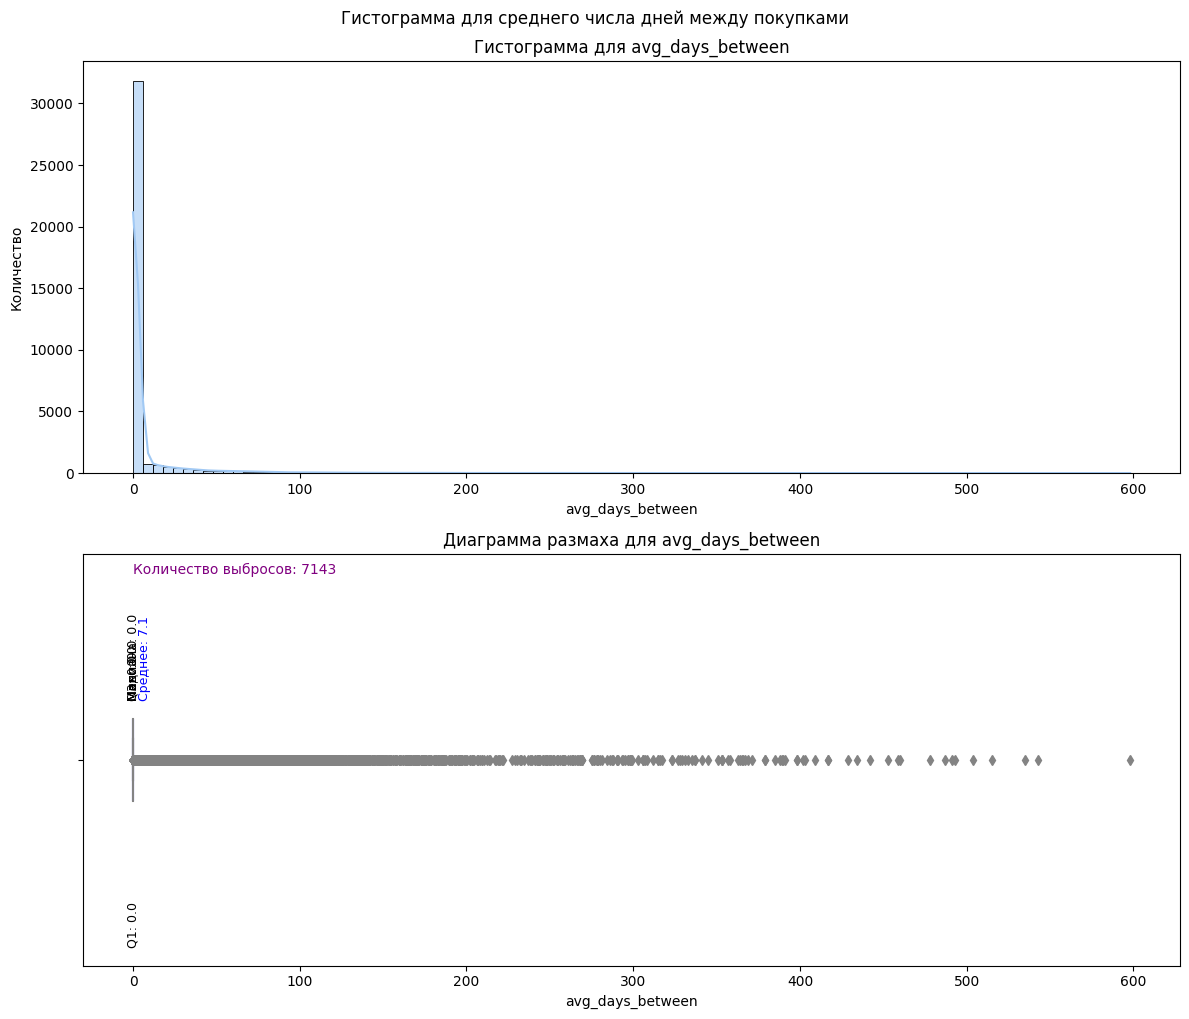

In [78]:
show_plot(df_merged, 'avg_days_between', new_bins=100, main_title='Гистограмма для среднего числа дней между покупками')

Имеется всплеск на значении 0. Он возник изза того, что некоторые покупатели делали несколько покупок и все в один день. Посмотрим для какого количества покупателей среднее время между покупками равно 0.

In [79]:
f"{df_merged[df_merged['avg_days_between'] == 0]['avg_days_between'].count() / df_merged['avg_days_between'].count() * 100: 0.1f}%"

' 80.5%'

Таких покупателей более 80%. Данный признак оказался неинформативным. Удалим этот признак из итогового датафрейма.

In [80]:
df_merged.drop('avg_days_between', axis=1, inplace=True)

Переведем категориальные столбцы в тип 'category'

In [81]:
cat_cols = [
    'client_id',
    'subcategory_0',
    'subcategory_1',
    'subcategory_2',
    'subcategory_3',
]  
df_merged[cat_cols] = df_merged[cat_cols].astype('category')

In [82]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   client_id           49849 non-null  category
 1   target              49849 non-null  category
 2   days_last_purchase  49849 non-null  float64 
 3   quantity_sum        49849 non-null  int64   
 4   price_mean          49849 non-null  float64 
 5   subcategory_0       49849 non-null  category
 6   subcategory_1       49849 non-null  category
 7   subcategory_2       49849 non-null  category
 8   subcategory_3       49849 non-null  category
 9   message_count       49849 non-null  float64 
 10  send                49849 non-null  float64 
 11  open                49849 non-null  float64 
 12  click               49849 non-null  float64 
 13  purchase            49849 non-null  float64 
 14  unsubscribe         49849 non-null  float64 
 15  complain            49849 non-null  

Пропуски обработаны. Типы данных приведены.

**Промежуточный итог:**

На этапе подготовки признаков таблицы были сгруппированы по id клиента. Созданы новые признаки. Таблицы объенинены. Проведен повторный анализ на наличие пропусков. Пропуски заполнены. Приведены типы данных. Данные подготовлены для обучения модели.

## 5 Корреляционный анализ данных

In [83]:
# количественные непрерывные признаки
num_continuous_features = [
    'days_last_purchase', 'price_mean', 'message_count', 'send', 'open',
    'click', 'purchase', 'unsubscribe', 'complain', 'subscribe',
    'close', 'email', 'mobile_push']

In [84]:
# уберем из анализа корреляций
drop_cols = ['client_id', 'subcategory_0', 'subcategory_1', 'subcategory_2', 'subcategory_3']

In [85]:
# Вычисляем матрицу корреляции phik
corr_matrix = df_merged.drop(columns=drop_cols).phik_matrix(interval_cols=num_continuous_features)

Для понятной визуализации информации запишем названия признаков на русском языке.

In [86]:
# перевод таблиц с английского на русский
eng_to_rus = {
    'target': 'Совершена покупка в целевом периоде',
    'days_last_purchase': 'Дней с последней покупки',
    'quantity_sum': 'Количество купленных товаров',
    'price_mean': 'Средняя цена покупки',
    'message_count': 'Количество рекламных сообщений',
    'send': 'Отправлено',
    'open': 'Открыто',
    'click': 'Переход по ссылке',
    'purchase': 'Покупка',
    'unsubscribe': 'Отписка',
    'complain': 'Жалоба',
    'subscribe': 'Подписка',
    'close': 'Окно закрыто',
    'email': 'Email',
    'mobile_push': 'Push-уведомление'
}

In [87]:
corr_matrix.rename(eng_to_rus, inplace=True)
corr_matrix.rename(columns=eng_to_rus, inplace=True)
corr_matrix

,Совершена покупка в целевом периоде,Дней с последней покупки,Количество купленных товаров,Средняя цена покупки,Количество рекламных сообщений,Отправлено,Открыто,Переход по ссылке,Покупка,Отписка,Жалоба,Подписка,Окно закрыто,Email,Push-уведомление
Совершена покупка в целевом периоде,1.000000,0.115966,0.141526,0.000000,0.056605,0.056753,0.048857,0.081011,0.099732,0.014954,0.000000,0.000000,0.000000,0.007746,0.058528
Дней с последней покупки,0.115966,1.000000,0.422294,0.057482,0.092908,0.092554,0.153268,0.044494,0.066978,0.061535,0.000000,0.000000,0.000000,0.228996,0.089666
Количество купленных товаров,0.141526,0.422294,1.000000,0.000000,0.123156,0.122937,0.041516,0.229648,0.872332,0.000000,0.000000,0.335557,0.000000,0.175287,0.284137
Средняя цена покупки,0.000000,0.057482,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011525,0.000000
Количество рекламных сообщений,0.056605,0.092908,0.123156,0.000000,1.000000,0.999995,0.687603,0.326852,0.024124,0.017533,0.000000,0.110627,0.000000,0.746776,0.912337
Отправлено,0.056753,0.092554,0.122937,0.000000,0.999995,1.000000,0.687273,0.326797,0.024415,0.017754,0.000000,0.110626,0.000000,0.746965,0.912417
Открыто,0.048857,0.153268,0.041516,0.000000,0.687603,0.687273,1.000000,0.260769,0.005078,0.015866,0.008052,0.088303,0.023777,0.158545,0.685985
Переход по ссылке,0.081011,0.044494,0.229648,0.000000,0.326852,0.326797,0.260769,1.000000,0.263595,0.000000,0.000000,0.027631,0.000000,0.272292,0.286147
Покупка,0.099732,0.066978,0.872332,0.000000,0.024124,0.024415,0.005078,0.263595,1.000000,0.000000,0.000000,0.000000,0.000000,0.047937,0.053283
Отписка,0.014954,0.061535,0.000000,0.000000,0.017533,0.017754,0.015866,0.000000,0.000000,1.000000,0.009479,0.336108,0.000000,0.147270,0.041839


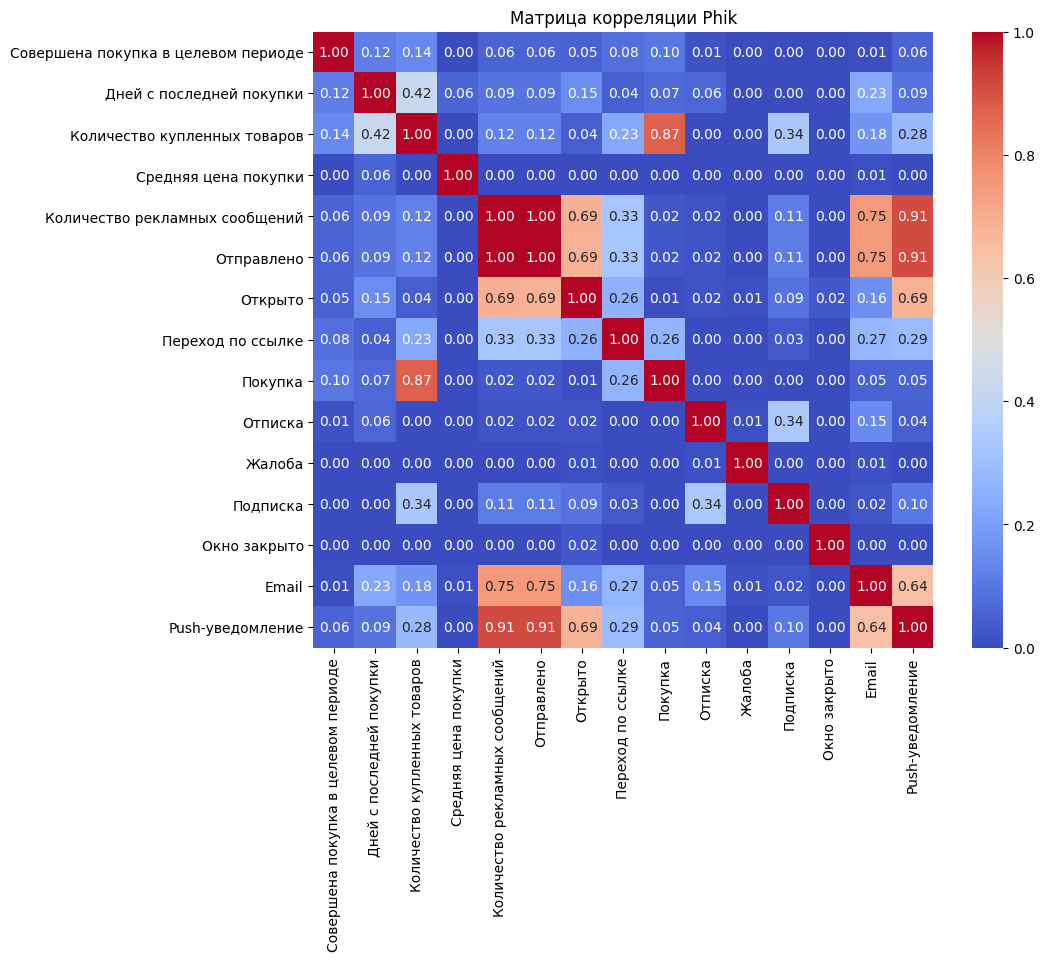

In [88]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляции Phik")
plt.show()

In [89]:
print_corr_levels(corr_matrix)

[('Весьма высокая корреляция между Количество рекламных сообщений и Отправлено:',
  1.0),
 ('Весьма высокая корреляция между Push-уведомление и Количество рекламных сообщений:',
  0.912),
 ('Весьма высокая корреляция между Push-уведомление и Отправлено:', 0.912),
 ('Высокая корреляция между Количество купленных товаров и Покупка:', 0.872),
 ('Высокая корреляция между Email и Количество рекламных сообщений:', 0.747),
 ('Высокая корреляция между Email и Отправлено:', 0.747),
 ('Заметная корреляция между Количество рекламных сообщений и Открыто:',
  0.688),
 ('Заметная корреляция между Открыто и Отправлено:', 0.687),
 ('Заметная корреляция между Push-уведомление и Открыто:', 0.686),
 ('Заметная корреляция между Email и Push-уведомление:', 0.643),
 ('Умеренная корреляция между Дней с последней покупки и Количество купленных товаров:',
  0.422),
 ('Умеренная корреляция между Количество купленных товаров и Подписка:',
  0.336),
 ('Умеренная корреляция между Отписка и Подписка:', 0.336),
 ('У

Имеется 100% колинеарность между Количество рекламных сообщений и Отправлено. Удалим из итогового датафрейма один из признаков.

Целевой признак имеет слабую корреляцию с Сумарным количеством купленных товаров и Количеством дней с последней покупки. 
Имеется нулевая корреляция целевого признака с признаками: средняя цена покупки, жалоба, подписка, окно закрыто. Не будем учитывать данные признаки при обучении модели.	

In [90]:
df_merged.drop(columns=['message_count', 'price_mean', 'complain', 'subscribe', 'close'])
df_merged.head()

,client_id,target,days_last_purchase,quantity_sum,price_mean,subcategory_0,subcategory_1,subcategory_2,subcategory_3,message_count,send,open,click,purchase,unsubscribe,complain,subscribe,close,email,mobile_push
0,1515915625468060902,0,630.0,7,999.000000,4,27,176,458,127.0,126.0,33.0,6.0,1.0,1.0,0.0,0.0,0.0,127.0,0.0
1,1515915625468061003,1,408.0,7,2319.285714,4,28,249,615,154.0,154.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,154.0,0.0
2,1515915625468061099,0,640.0,1,299.000000,4,28,290,424,215.0,215.0,49.0,8.0,0.0,0.0,0.0,0.0,0.0,157.0,58.0
3,1515915625468061100,0,6.0,2,1049.000000,4,27,1828,5717,268.0,267.0,153.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,268.0
4,1515915625468061170,0,244.0,19,1768.473684,4,28,260,420,243.0,243.0,30.0,12.0,3.0,0.0,0.0,0.0,0.0,164.0,79.0


**Промежуточный итог:**

По результатам корреляционного анализа были удалены мультиколинеарные признаки и признаки, неимеющие корреляции с таргетом.

## 6 Обучение моделей

Для обучения будем использовать модель LightGBM. Попробуем обучить модель с учетом наиболее популярных категорий товаров и без.

**6.1 Модель с учетом наиболее популярных категорий товаров**

In [91]:
cat_features = ['subcategory_0', 'subcategory_1', 'subcategory_2', 'subcategory_3']

In [92]:
# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['client_id', 'target'], axis=1),
    df_merged['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [93]:
# Создадим сетку для перебора и гиперпараметров
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [94]:
model = LGBMClassifier(random_state=RANDOM_STATE)

# Запуск GridSearchCV для поиска лучшей модели и гиперпараметров
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

start = time.time()
grid_search.fit(X_train, y_train, categorical_feature=cat_features)
end = time.time()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 693, number of negative: 36693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2735
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018536 -> initscore=-3.969311
[LightGBM] [Info] Start training from score -3.969311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [95]:
# выведем параметры и метрику лучшей модели
print('Лучшая модель и её параметры:\n    ', grid_search.best_params_)
print(f'\nМетрика ROC-AUC для лучшей модели: {grid_search.best_score_:.3f}') 
print(f"Время перебора гиперпараметров модели: {end - start:.2f} секунд")

Лучшая модель и её параметры:
     {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}

Метрика ROC-AUC для лучшей модели: 0.693
Время перебора гиперпараметров модели: 61.44 секунд


Метрика ROC-AUC получилась меньше таргета

Удалим столбцы с категориями наиболее популярных товаров.

In [96]:
df_merged = df_merged.drop(['subcategory_0', 'subcategory_1', 'subcategory_2', 'subcategory_3'], axis=1)

**6.2 Модель без учета наиболее популярных категорий товаров**

In [97]:
# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['client_id', 'target'], axis=1),
    df_merged['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [98]:
model = LGBMClassifier(random_state=RANDOM_STATE)

# Запуск GridSearchCV для поиска лучшей модели и гиперпараметров
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()

[LightGBM] [Info] Number of positive: 693, number of negative: 36693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018536 -> initscore=-3.969311
[LightGBM] [Info] Start training from score -3.969311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [99]:
# выведем параметры и метрику лучшей модели
print('Лучшая модель и её параметры:\n    ', grid_search.best_params_)
print(f'\nМетрика ROC-AUC для лучшей модели: {grid_search.best_score_:.3f}') 
print(f"Время перебора гиперпараметров модели: {end - start:.2f} секунд")

Лучшая модель и её параметры:
     {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}

Метрика ROC-AUC для лучшей модели: 0.741
Время перебора гиперпараметров модели: 43.16 секунд


Целевой показатель ROC-AUC > 0.7 получен. 
Оценим модель на тестовой выборке.

In [100]:
y_test_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_test_pred = grid_search.predict(X_test)
print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred_proba), 3))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_pred), 3))
print("Recall:", round(recall_score(y_test, y_test_pred), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.749
Accuracy: 0.978
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\egor1\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision, Recall, F1 = 0.0 говорит о том, что модель совсем не находит второй класс.

Попробуем обучить модель с учетом дисбаланса классов в целевом признаке.

**6.3 Модель с учетом дисбаланса классов**

In [101]:
model = LGBMClassifier(
    random_state=RANDOM_STATE, 
    scale_pos_weight=target_weight_scale
)

# Запуск GridSearchCV для поиска лучшей модели и гиперпараметров
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()

[LightGBM] [Info] Number of positive: 693, number of negative: 36693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018536 -> initscore=-3.969311
[LightGBM] [Info] Start training from score -3.969311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [102]:
# выведем параметры и метрику лучшей модели
print('Лучшая модель и её параметры:\n    ', grid_search.best_params_)
print(f'\nМетрика ROC-AUC для лучшей модели: {grid_search.best_score_:.3f}') 
print(f"Время перебора гиперпараметров модели: {end - start:.2f} секунд")

Лучшая модель и её параметры:
     {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}

Метрика ROC-AUC для лучшей модели: 0.733
Время перебора гиперпараметров модели: 45.03 секунд


Целевой показатель ROC-AUC > 0.7 получен. 
Оценим модель на тестовой выборке.

In [103]:
y_test_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_test_pred = grid_search.predict(X_test)
print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred_proba), 3))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_pred), 3))
print("Recall:", round(recall_score(y_test, y_test_pred), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.747
Accuracy: 0.964
Precision: 0.138
Recall: 0.127
F1 score: 0.132


Хотя ROC-AUC модели: 0.747, низкие показатели Precision, Recall, F1 говорит о том, что модель правильно предсказывает только 13% будущих покупателей.

Accuracy: 0.964 - высокая из-за большого дисбаланса классов.

**6.4 Модель с учетом дисбаланса классов и порогом 0,3**

Попробуем уменьшить порог классификации, чтобы увеличить точность предсказания именно покупателей класса 1.

In [104]:
# Устанавливаем свой порог
threshold = 0.3

# Классификация вручную по порогу
y_test_pred = (y_test_pred_proba >= threshold).astype(int)
print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred_proba), 3))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_pred), 3))
print("Recall:", round(recall_score(y_test, y_test_pred), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.747
Accuracy: 0.713
Precision: 0.049
Recall: 0.675
F1 score: 0.092


**Промежуточный итог:**

Для предсказания совершения клиентом покупки в течение следующих 90 дней была обучена модель LGBM Classifier.

ROC-AUC модели: 0.747 - что значит, что модель научилась неплохо различать классы.

При пороге классификации 0,3 Precision модели уменьшился до 0,713, однако Recall вырос до 0,675, что говорит о том, что модель точно предсказывает более 2/3 будущих покупателей.

При этом Precision модели уменьшился с 0,132 до 0.049.

## 7. Анализ важности признаков

Оценим важность признаков лучшей модели. Для оценки будем использовать метод SHAP.

In [105]:
# Подготовим модель и данные
model = grid_search.best_estimator_

In [106]:
explainer = shap.PermutationExplainer(model.predict_proba, X_train)

In [107]:
shap_values = explainer(X_test)

PermutationExplainer explainer: 12464it [13:40, 15.06it/s]                                                             


In [108]:
labels = X_train.columns
labels

Index(['days_last_purchase', 'quantity_sum', 'price_mean', 'message_count',
       'send', 'open', 'click', 'purchase', 'unsubscribe', 'complain',
       'subscribe', 'close', 'email', 'mobile_push'],
      dtype='object')

In [109]:
labels_rus = [
    'Дней с последней покупки',
    'Суммарное количество товаров',
    'Средняя цена',
    'Количество сообщений',
    'Отправлено',
    'Открытие',
    'Переход по ссылке',
    'Покупка',
    'Отписка',
    'Жалоба',
    'Подписка',
    'Закрытие',
    'Email',
    'Push-уведомление'
]

In [110]:
shap_values_fixed = shap.Explanation(
    values=shap_values.values[..., 1],
    base_values=shap_values.base_values[..., 1],  
    data=X_test,  
    feature_names=labels_rus
)

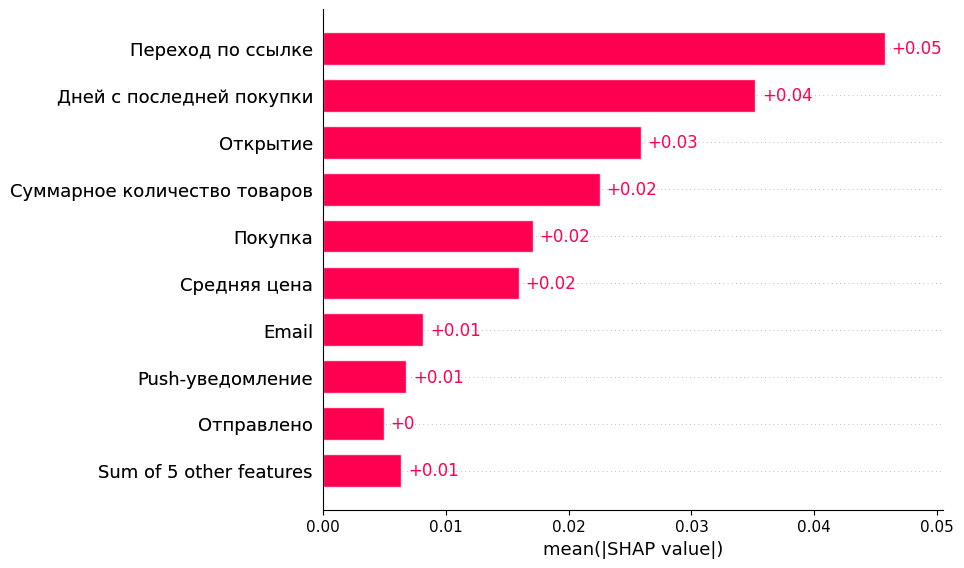

In [111]:
# shap вызывался с ошибкой, попросил ChatGPT сделать патч
_original_set_yticks = plt.Axes.set_yticks

def patched_set_yticks(self, ticks, labels=None, **kwargs):
    # В matplotlib set_yticks не принимает fontsize — задаём только ticks
    _original_set_yticks(self, ticks)
    if labels is not None:
        self.set_yticklabels(labels, **kwargs)

# Патчим метод Axes.set_yticks
plt.Axes.set_yticks = patched_set_yticks

# Теперь вызов shap.plots.bar должен работать без ошибки
shap.plots.bar(shap_values_fixed)

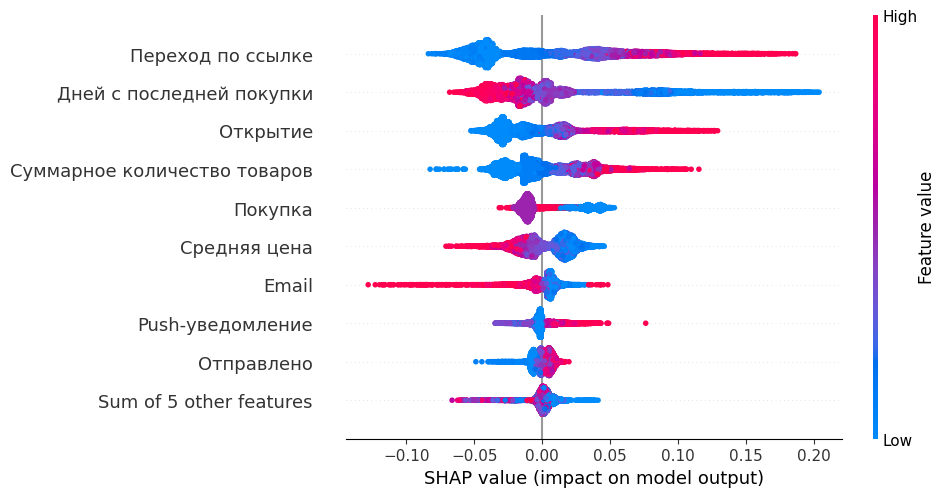

In [112]:
shap.plots.beeswarm(shap_values_fixed) 

**Промежуточный итог:**

Анализ важности признаков показал, что ни один из признаков не вностит существенный вклад в предсказание модели. 

Наиболее важными признаками оказались: Переход по ссылке, Дней с последней покупки, Открытие рекламного сообщения и Суммарное количество купленных товаров.

## Общий вывод

**Общий вывод**

Целью проекта было разработать модель бинарной классификации для прогнозирования вероятности совершения покупки пользователем в течение 90 дней на основе данных онлайн-магазина. Это позволит оптимизировать маркетинговые рассылки и повысить эффективность продаж.

**Задачи**, которые были решены:
* Проведёна предварительная обработка предосталенных данных о покупках и рекламных рассылках;
* Выполнена обработка признаков, включающая сгруппировку, агрегацию данных и создание новых признаков;
* Проведен исследовательский анализ данных. Данные визуализированы.
* Исследованы корреляции и произведен отбор признаков
* Обработан дисбаланс классов с помощью настройки весов и подбора порога классификации;
* Обучена и оптимизирована модель LightGBM с подбором гиперпараметров через GridSearchCV;
* Проведена оценка модели с использованием нескольких метрик, включая ROC-AUC, Precision, Recall и F1-score;
* Оценена важность признаков.
  
**Ключевые выводы:**
* Модель показывает хорошую способность к разделению классов (ROC-AUC ~0.75), однако, вследствие большого дисбаланса классов, Precision и Recall имеют низкие значения;
* Уменьшение порога классификации значительно улучшает Recall (полноту охвата пользователей, готовых сделать покупки в течение 90 дней). Однако при этом Precision модели уменьшается до 0,049, что говорит о том что 19 пользователей из 20 будут неправильно определяться как готовые совершить покупку.

**Предложения:**
* Увеличить количество пользователей класса 1 в выборке для уменьшения дисбаланса классов;
* Продолжить исследование данных с целью находжения новых зависимостей и признаков;
* Рассмотреть внедрение дополнительных признаков, к примеру опыт взаимодействия с платформой (как часто заходит в приложение, сколько товаров в корзине, сколько товаров в избранном и т.д.);

In [114]:
!pip freeze > requirements.txt